# PRV Assignment 2

- Pablo Garcia Fernández

Initial configuration

In [1]:
# Initial configuration
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

#######################################
## PREDIFINE CONSTATNS OF THE EXERCISE
F = 2406.1 # focal length in pixels 

### 1 - Obtain correspondence points from undistorted images 

In [2]:
def obtain_points(img1_n, img2_n, k=20000, no_matches=8, pintar=False):
    img1 = cv.imread(img1_n, cv.IMREAD_GRAYSCALE) 
    img2 = cv.imread(img2_n, cv.IMREAD_GRAYSCALE)

    sift = cv.SIFT_create(k)
    kp1, des1 = sift.detectAndCompute(img1, None) # q
    kp2, des2 = sift.detectAndCompute(img2, None) # t

    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = bf.match(des1, des2)
    print(f"Total no. matches: {len(matches)}")
    matches = (sorted(matches, key = lambda x:x.distance))[:no_matches]
    print(f"Keep no. matches: {len(matches)}")
    
    if pintar:
        img3 = cv.drawMatches(img1, kp1, img2, kp2, matches, img2, flags=2)
        plt.imshow(img3)
        plt.savefig(img1_n + img2_n + ".png", dpi=400)
        #plt.show()

    # Get points of the matches https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python
    # Each point -> (col, row)
    list_kp1 = [kp1[mat.queryIdx].pt for mat in matches] 
    list_kp2 = [kp2[mat.trainIdx].pt for mat in matches]
    
    return list_kp1, list_kp2

Total no. matches: 12354
Keep no. matches: 8


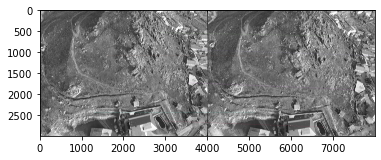

In [3]:
list_kp1, list_kp2 = obtain_points('DJI_0186.jpg', 'DJI_0187.jpg', pintar=True)

In [4]:
print(list_kp1)
print(list_kp2)

[(3550.252197265625, 1723.578125), (1606.626953125, 1081.4862060546875), (3549.142333984375, 1734.109375), (2936.12060546875, 2638.871337890625), (2878.027099609375, 538.8202514648438), (3780.427978515625, 945.3861083984375), (1293.89990234375, 2443.99658203125), (1486.731689453125, 2947.65673828125)]
[(3527.325927734375, 1889.9796142578125), (1544.174560546875, 1093.7490234375), (3525.247314453125, 1900.77001953125), (2771.706787109375, 2786.341552734375), (2903.38623046875, 615.8174438476562), (3882.265625, 1085.1976318359375), (1115.9364013671875, 2432.957763671875), (1241.10400390625, 2960.7412109375)]


### 2 - Relative orientation 

In [26]:
def conditioning(list_kp1, list_kp2):

    # CONDITIONING
    av_kp1 = np.average(list_kp1, axis=0)
    av_kp2 = np.average(list_kp2, axis=0)

    list_kp1_conditioned = list_kp1 - av_kp1
    list_kp2_conditioned = list_kp2 - av_kp2

    max_kp1 = np.max(np.abs(list_kp1_conditioned))
    list_kp1_conditioned = list_kp1_conditioned / max_kp1

    max_kp2 = np.max(np.abs(list_kp2_conditioned))
    list_kp2_conditioned = list_kp2_conditioned / max_kp2

    # Matrices para realizar el posterior des-CONDITIONING
    T1 = np.array([[1, 0, -av_kp1[0]], 
                   [0, 1, -av_kp1[1]], 
                   [0, 0, max_kp1]])

    T2 = np.array([[1, 0, -av_kp2[0]], 
                   [0, 1, -av_kp2[1]], 
                   [0, 0, max_kp2]])

    return list_kp1_conditioned, list_kp2_conditioned, T1, T2


def obtain_3d_coordinates(list_kp1, list_kp2, img1_shape, img2_shape, focal_px):
    list_kp1_final = []
    list_kp2_final = []

    for p1, p2 in zip(list_kp1, list_kp2):
        # La imagen esta en h,w (y,x)
        # Como el (0,0) de la imagen esta arriba a la izq -> corregir
        p1 = np.array([img1_shape[0], 0]) - p1
        p2 = np.array([img2_shape[0], 0]) - p2

        # Translate to h/2, w/2
        p1 = p1 - np.array([img1_shape[1]/2, img1_shape[0]/2])
        p2 = p2 - np.array([img2_shape[1]/2, img2_shape[0]/2])

        # Append c 
        p1 = np.append(p1, focal_px)
        p2 = np.append(p2, focal_px)

        list_kp1_final.append(p1)
        list_kp2_final.append(p2)
    
    return np.array(list_kp1_final), np.array(list_kp2_final)



def relative_orientation(list_kp1, list_kp2, focal_px, img1_shape, img2_shape):

    ## OBTAIN 3D COORDINATES
    print("OBTAIN 3D COORDINATES")
    print(f"h: {img1_shape[1]}, w:{img1_shape[0]}, F: {focal_px}")
    print(f"Ejemplo 2d coordinates \n{list_kp1[0]}, {list_kp2[0]}")
    kp1, kp2 = obtain_3d_coordinates(list_kp1, list_kp2, img1_shape, img2_shape, focal_px)
    print(f"a 3d coordinates:\n({kp1[0][0]}, {kp1[0][1]}, {kp1[0][2]}), ({kp2[0][0]}, {kp2[0][1]}, {kp2[0][2]})\n")
    

    ## CONDITIONING
    print("CONDITIONING")
    #kp1, kp2, T1, T2 = conditioning(kp1, kp2)
    print(f"kp1 condicionado: \n{kp1}")
    print(f"\nkp2 condicionado: \n{kp2}")


    ## BUILD EQUATION MATRIX
    eq_matrix = []
    for p1, p2 in zip(kp1, kp2):
        # Create ai
        ai = np.array([p2[0] * p1[0],
                    p2[0] * p1[1],
                    p2[0],
                    p2[1] * p1[0],
                    p2[1] * p1[1],
                    p2[1],
                    p1[0],
                    p1[1],
                    1 
        ])
        eq_matrix.append(ai)
    eq_matrix = np.array(eq_matrix)
    print("\nBUILD EQUATION MATRIX")
    print(f"Equation matrix: \n{eq_matrix}")

    ## Solve the system of equations obtaining the SVD of the matrix
    _, _, vt = np.linalg.svd(eq_matrix)
    e_est = vt[:,-1].reshape((3,3))

    # Apply restrictions of the essential matrix: non-zero singular values are equal and the third is zero
    U, d, V = np.linalg.svd(e_est)
    diag_ = np.array([[1,0,0], [0,1,0], [0,0,0]])
    E = U @ diag_ @ V
    print(f"\nESSENTIAL MATRIX E CONDITIONED: \n{E}")
    # DECONDITIONING
    #E = T2.T @ E @ np.linalg.inv(T1)
    print(f"\nESSENTIAL MATRIX E DE-CONDITIONED: \n{E}")

    # OBTAIN U, V FROM E
    U, d, V = np.linalg.svd(E)
    # Obtain 2 solutions for both R and b
    # Auxiliar matrices:
    W = np.array([[0,1,0], [-1,0,0], [0,0,1]])
    Z = np.array([[0,1,0], [-1,0,0], [0,0,0]])
    R1 = U @ W @ V
    R2 = U @ W.T @ V
    b1 = U @ Z @ U.T
    b2 = U @ Z.T @ U.T
    print(f"\nR1:\n {R1}\nR2:\n {R1}\nb1:\n {b1}\nb2:\n {b2}\n")

    return R1, R2, b1,b2
   

img1 = cv.imread('DJI_0186.jpg', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('DJI_0187.jpg', cv.IMREAD_GRAYSCALE)

R1, R2, b1,b2 = relative_orientation(list_kp1, list_kp2, F, img1.shape, img2.shape)

OBTAIN 3D COORDINATES
h: 4000, w:3000, F: 2406.1
Ejemplo 2d coordinates 
(3550.252197265625, 1723.578125), (3527.325927734375, 1889.9796142578125)
a 3d coordinates:
(-2550.252197265625, -3223.578125, 2406.1), (-2527.325927734375, -3389.9796142578125, 2406.1)

CONDITIONING
kp1 condicionado: 
[[-2550.25219727 -3223.578125    2406.1       ]
 [ -606.62695312 -2581.48620605  2406.1       ]
 [-2549.14233398 -3234.109375    2406.1       ]
 [-1936.12060547 -4138.87133789  2406.1       ]
 [-1878.02709961 -2038.82025146  2406.1       ]
 [-2780.42797852 -2445.3861084   2406.1       ]
 [ -293.89990234 -3943.99658203  2406.1       ]
 [ -486.73168945 -4447.65673828  2406.1       ]]

kp2 condicionado: 
[[-2527.32592773 -3389.97961426  2406.1       ]
 [ -544.17456055 -2593.74902344  2406.1       ]
 [-2525.24731445 -3400.77001953  2406.1       ]
 [-1771.70678711 -4286.34155273  2406.1       ]
 [-1903.38623047 -2115.81744385  2406.1       ]
 [-2882.265625   -2585.19763184  2406.1       ]
 [ -115.9364013

In [34]:
# Longuet-Higgins
# 3D points -> X,Y,Z
def triangulation(point1, point2, R, b):
    point2 = b @ R @ point2
    triangulation = np.cross(point1, point2) 
    return triangulation

# Prueba
point1 = np.array(list_kp1[0])
point1 = point1 - np.array([img1.shape[1]/2, img1.shape[0]/2])
point1 = np.append(point1, F)

point2 = np.array(list_kp2[0])
point2 = point2 - np.array([img2.shape[1]/2, img2.shape[0]/2])
point2 = np.append(point2, F)

asd = triangulation(point1, point2, R1, b1)
print(asd)


[-1489977.00200535  3712525.52511775   615020.41698748]
